In [1]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import initializers

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [48]:
np.random.seed(1000)
nrows = 28
ncols = 28
nchannels = 1
z_dim = 128
epochs = 100
batch_size = 256
adam = Adam(lr=0.0002, beta_1=0.5)

In [49]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5)/127.5

In [50]:
generator = Sequential()

generator.add(Dense(7*7*128, input_shape=(z_dim,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((7,7,128)))

generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(LeakyReLU(0.2))

generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(32, 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(LeakyReLU(0.2))

generator.add(Conv2D(1, 5, padding='same', activation='tanh'))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 14, 14, 64)        0         
__________

In [51]:
discriminator = Sequential()

discriminator.add(Conv2D(32, 5, strides=2, padding='same', input_shape=(nrows,ncols,nchannels)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(64, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

discriminator.compile(loss='binary_crossentropy', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 7, 7, 128)         204928    
__________

In [52]:
discriminator.trainable = False
gan_input = Input(shape=(z_dim,))
gen_image = generator(gan_input)
gan_output = discriminator(gen_image)

conv_gan = Model(inputs=gan_input, outputs=gan_output)
conv_gan.compile(loss='binary_crossentropy', optimizer=adam)

############# Epoch 0 #############


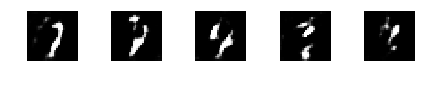

############# Epoch 10 #############


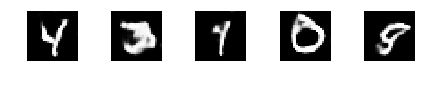

############# Epoch 20 #############


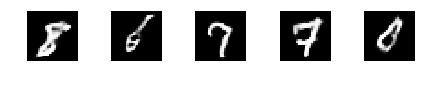

############# Epoch 30 #############


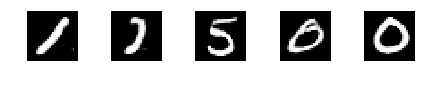

############# Epoch 40 #############


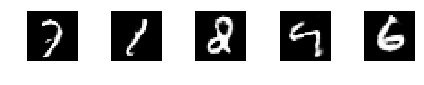

############# Epoch 50 #############


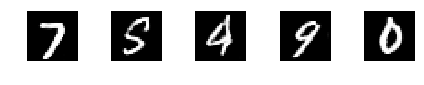

############# Epoch 60 #############


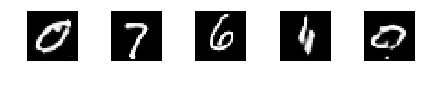

############# Epoch 70 #############


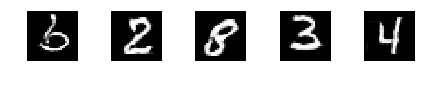

############# Epoch 80 #############


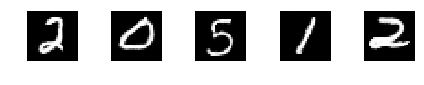

############# Epoch 90 #############


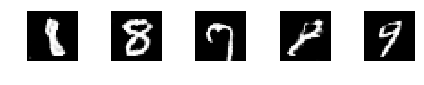

############# Epoch 99 #############


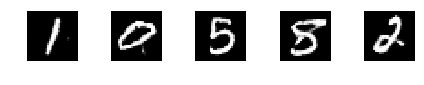

In [53]:
dloss_list = []
gloss_list = []
nbatch = x_train.shape[0]//batch_size

for i in range(epochs):    
    for nb in range(nbatch):
        # Train discriminator

        # Generate fake images
        z = np.random.normal(0, 1, size=[batch_size, z_dim])    
        gen_images = generator.predict(z)

        # Sample real images
        idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        real_images = x_train[idx].reshape(batch_size,nrows,ncols,nchannels)

        combined_images = np.concatenate([gen_images, real_images])
        ydis = np.zeros(2*batch_size)
        ydis[batch_size:] = 1
        
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(combined_images, ydis)       

        # Train generator    

        z = np.random.normal(0, 1, size=[batch_size, z_dim])

        ygen = np.ones(batch_size)
        discriminator.trainable = False
        gloss = conv_gan.train_on_batch(z, ygen)
    
    dloss_list.append(dloss)
    gloss_list.append(gloss)
    
    # Display sample generated images
    idx = np.random.randint(0, batch_size, size=5)
    sample_gen_images = gen_images[idx]        
    
    if i%10 == 0 or i == epochs-1:
        print('############# Epoch %d #############'% i)
        plt.figure(figsize=(6, 6))
        for j in range(sample_gen_images.shape[0]):
            plt.subplot(1, 5, j+1)
            image = sample_gen_images[j, :, :, :]            
            image = np.reshape(image, [nrows, ncols])            
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

generator.save('mnist_conv_gan_genarator.h5')
discriminator.save('mnist_conv_gan_discriminator.h5')

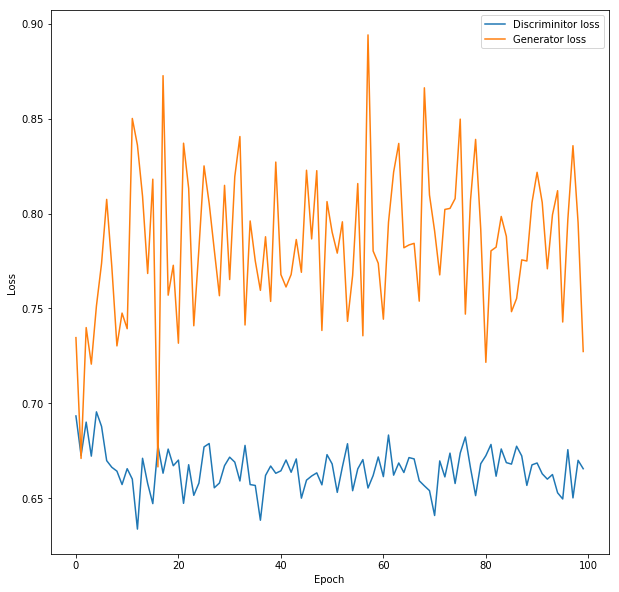

In [54]:
plt.figure(figsize=(10, 10))
plt.plot(dloss_list, label='Discriminitor loss')
plt.plot(gloss_list, label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

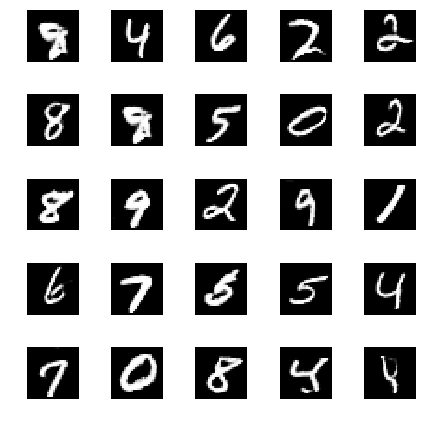

In [56]:
# Display sample generated images
z = np.random.normal(0, 1, size=[batch_size, z_dim])    
gen_images = generator.predict(z)
idx = np.random.randint(0, batch_size, size=25)
sample_gen_images = gen_images[idx]        

plt.figure(figsize=(6, 6))
for j in range(sample_gen_images.shape[0]):
    plt.subplot(5, 5, j+1)
    image = sample_gen_images[j, :, :, :]            
    image = np.reshape(image, [nrows, ncols])            
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()